In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install datasets
!pip install transformers
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Basic part

In [3]:
# We firstly download the dataset.
from datasets import load_dataset
raw_datasets = load_dataset("financial_phrasebank", 'sentences_allagree')

  0%|          | 0/1 [00:00<?, ?it/s]

In [48]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2264
    })
})

We can see that our dataset has 2264 records and 2 features: 'sentence' and 'label' where 'sentence' is the input to be sentimentally evaluated and 'label' is the evaluation result.

In [51]:
raw_datasets['train'].features

{'sentence': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

We can see that 'sentence' is string type and 'label' is ClassLabel type which has three values (negative--0, neutral--1, positive--2).

### Data preprocessing

In [4]:
# We use the html module to unescape the HTML character codes in our 'sentence' in case of their presence, which is like:
import html
raw_datasets = raw_datasets.map(
    lambda x: {"sentence": [html.unescape(o) for o in x["sentence"]]}, batched=True
)

We plot the histogram of the length of sentences:

(array([125., 717., 679., 413., 197., 103.,  28.,   1.,   0.,   1.]),
 array([ 2. ,  9.9, 17.8, 25.7, 33.6, 41.5, 49.4, 57.3, 65.2, 73.1, 81. ]),
 <BarContainer object of 10 artists>)

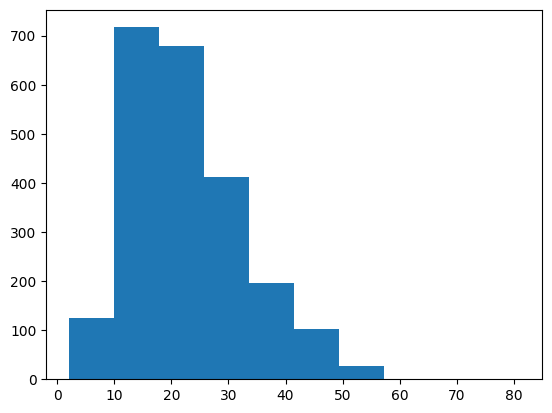

In [5]:
sen_length = []
for i in range(len(raw_datasets["train"]['sentence'])):
    sen_length.append(len(raw_datasets["train"]['sentence'][i].split()))
plt.hist(sen_length)

We find that there are no superlong sentences, so we don't split sentences to create more features now.

We split the dataset into three parts: "Train" set (60%), "Validation" set (20%), "Test" set (20%):

In [6]:
fin_dataset_clean = raw_datasets["train"].train_test_split(train_size=0.6, seed=42)
fin_dataset_clean_temp = fin_dataset_clean['test'].train_test_split(train_size=0.5, seed=42)
fin_dataset_clean["validation"] = fin_dataset_clean_temp["train"]
fin_dataset_clean["test"] = fin_dataset_clean_temp["test"]
fin_dataset_clean

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 1358
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 453
    })
    validation: Dataset({
        features: ['sentence', 'label'],
        num_rows: 453
    })
})

We tokenize the sentences and use batches here:

In [7]:
from transformers import AutoTokenizer
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["sentence"], truncation=True)

from transformers import DataCollatorWithPadding
tokenized_datasets = fin_dataset_clean.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

Map:   0%|          | 0/453 [00:00<?, ? examples/s]

In [8]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1358
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 453
    })
    validation: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 453
    })
})

Now we have dataset for train, validation and test, and they are tokenized. Now we transform the dataset into tensorflow form.

In [9]:
tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols="labels",
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_validation_dataset = tokenized_datasets["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols="labels",
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

tf_test_dataset = tokenized_datasets["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols="labels",
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


### No fine-tune
In this part we don't fine-tune any layer and use it as a base case.

In [10]:
## get the model
from transformers import TFAutoModelForSequenceClassification
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [11]:
## predict the result for the test dataset
preds = model.predict(tf_test_dataset)["logits"]
class_preds = np.argmax(preds, axis=1)

## calculate accuracy and f1 score
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(class_preds, fin_dataset_clean["test"]["label"])
f1 = f1_score(class_preds, fin_dataset_clean["test"]["label"], average = "macro")
print("accuracy score = ", accuracy, "\nf1 score = ", f1)

57/57 [==============================] - 7s 22ms/step
accuracy score =  0.1434878587196468 
f1 score =  0.08718980549966465


The prediction accuracy is very low, even less than random guessing. This shows that without fine-tuning, the model can hardly predict sentiment. This calls for fine-tuning the model.

### Fine-tune only the Classifier head
In this part we only fine-tune the Classifier head.

In [12]:
## get the model
model1 = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use i

In [13]:
## see the layers of the model
model1.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0
_________________________________________________________________


We see that there are three layers and a dropout layer in the model. We shall freeze the first and second layer and only fine-tune the classifier layer.

We lower the learning rate and slowly reduce the learning rate over the course of training so that we get a new optimizer and accelerate the training.

In [14]:
# set optimizer
from tensorflow.keras.optimizers.schedules import PolynomialDecay
batch_size = 8
num_epochs = 3
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=lr_scheduler)

# freeze first and second layer and fine-tune the model
model1.layers[0].trainable = False
model1.layers[1].trainable = False
import tensorflow as tf
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model1.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
model1.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=3)

Epoch 1/3
170/170 [==============================] - 14s 37ms/step - loss: 1.0115 - accuracy: 0.6082 - val_loss: 0.9519 - val_accuracy: 0.6291
Epoch 2/3
170/170 [==============================] - 4s 24ms/step - loss: 0.9359 - accuracy: 0.6149 - val_loss: 0.9155 - val_accuracy: 0.6291
Epoch 3/3
170/170 [==============================] - 4s 23ms/step - loss: 0.9176 - accuracy: 0.6149 - val_loss: 0.9076 - val_accuracy: 0.6291


In [15]:
## predict the result for the test dataset
preds1 = model1.predict(tf_test_dataset)["logits"]
class_preds1 = np.argmax(preds1, axis=1)

## calculate accuracy and f1 score
accuracy = accuracy_score(class_preds1, fin_dataset_clean["test"]["label"])
f1 = f1_score(class_preds1, fin_dataset_clean["test"]["label"], average = "macro")
print("accuracy score = ", accuracy, "\nf1 score = ", f1)

57/57 [==============================] - 3s 18ms/step
accuracy score =  0.5982339955849889 
f1 score =  0.24953959484346222


The results show that the accuracy has increased, but is still not so high, just around 60%. This shows that fine-tuning the classifer layer helps sentiment prediction as it is now privatized to our dataset, but it is still not enough.

### Fine-tune all the weights
In this part we fine-tune all the layers and the prediction result shall be better.

In [16]:
# new optimizer
batch_size = 8
num_epochs = 3
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
opt = Adam(learning_rate=lr_scheduler)

In [17]:
## get, compile and train the model
model2 = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model2.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
model2.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=3)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/3
170/170 [==============================] - 58s 199ms/step - loss: 0.3796 - accuracy: 0.8498 - val_loss: 0.1697 - val_accuracy: 0.9404
Epoch 2/3
170/170 [==============================] - 11s 67ms/step - loss: 0.0738 - accuracy: 0.9809 - val_loss: 0.1604 - val_accuracy: 0.9514
Epoch 3/3
170/170 [==============================] - 9s 52ms/step - loss: 0.0278 - accuracy: 0.9926 - val_loss: 0.1251 - val_accuracy: 0.9691


In [18]:
## predict the result for the test dataset
preds2 = model2.predict(tf_test_dataset)["logits"]
class_preds2 = np.argmax(preds2, axis=1)

## calculate accuracy and f1 score
accuracy_train2 = accuracy_score(class_preds2, fin_dataset_clean["test"]["label"])
f1_train2 = f1_score(class_preds2, fin_dataset_clean["test"]["label"], average = "macro")
print("accuracy score = ", accuracy_train2, "\nf1 score = ", f1_train2)

57/57 [==============================] - 2s 15ms/step
accuracy score =  0.9580573951434879 
f1 score =  0.9443788951996103


We can see that the accuracy has increased a lot and is around 95%. This shows that the fine-tuned model works pretty well on our dataset and it is necessary to do fine-tuning on our dataset. The huge improvement is probably due to the huge power of the first two layers as they have many more parameters and so the fine-tuning of them can lead to great leap in prediction accuracy.

# Extra part

### 1.Create own Classification head
In this part we design and use our own classification head.

In [19]:
from transformers import DistilBertTokenizerFast, TFDistilBertModel
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
bert = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [20]:
## This is the function where we design our head
from tensorflow import keras
from tensorflow.keras import layers
class TextClassificationModel(keras.Model):
  def __init__(self, encoder, train_encoder=True):
    super(TextClassificationModel, self).__init__()
    self.encoder = encoder
    self.encoder.trainable = train_encoder
    self.dropout1 = layers.Dropout(0.1)
    self.dropout2 = layers.Dropout(0.1)
    self.dense1 = layers.Dense(80, activation="relu")
    self.dense2 = layers.Dense(20, activation="relu")
    self.dense3 = layers.Dense(3, activation='softmax')
  
  def call(self, input):
    x = self.encoder(input)
    x = x['last_hidden_state'][:, 0, :]
    x = self.dropout1(x)
    x = self.dense1(x)
    x = self.dropout2(x)
    x = self.dense2(x)
    x = self.dense3(x)
    return x

In [21]:
train_texts, train_labels = raw_datasets["train"]["sentence"], raw_datasets["train"]["label"]

In [22]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.4)
val_texts, test_texts, val_labels, test_labels = train_test_split(val_texts, val_labels, test_size=.5)

In [23]:
## We choose 128 as max_length because all sentences are less than 128 in length and we can preserve all information.
train_encodings = tokenizer(train_texts, truncation=True, padding="max_length", max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding="max_length", max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding="max_length", max_length=128)

In [24]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

In [25]:
text_classification_model = TextClassificationModel(bert, train_encoder=False)

In [26]:
first_batch_outputs = text_classification_model(next(iter(train_dataset.batch(8))))

In [27]:
## We can see the layers of our model here
text_classification_model.summary()

Model: "text_classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_distil_bert_model (TFDis  multiple                 66362880  
 tilBertModel)                                                   
                                                                 
 dropout_79 (Dropout)        multiple                  0         
                                                                 
 dropout_80 (Dropout)        multiple                  0         
                                                                 
 dense (Dense)               multiple                  61520     
                                                                 
 dense_1 (Dense)             multiple                  1620      
                                                                 
 dense_2 (Dense)             multiple                  63        
                                         

In [28]:
## optimizer
batch_size = 8
num_epochs = 3
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
opt = Adam(learning_rate=lr_scheduler)

## compile and fit model
loss = tf.keras.losses.SparseCategoricalCrossentropy()
text_classification_model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
# text_classification_model.compile(tf.keras.optimizers.Adam(learning_rate=5e-5), "sparse_categorical_crossentropy", metrics=["accuracy"])
text_classification_model.fit(train_dataset.batch(8), validation_data=val_dataset.batch(8), epochs=3)

Epoch 1/3
170/170 [==============================] - 15s 40ms/step - loss: 0.9605 - accuracy: 0.5773 - val_loss: 0.8557 - val_accuracy: 0.6225
Epoch 2/3
170/170 [==============================] - 5s 32ms/step - loss: 0.8671 - accuracy: 0.6193 - val_loss: 0.8025 - val_accuracy: 0.6247
Epoch 3/3
170/170 [==============================] - 6s 33ms/step - loss: 0.8360 - accuracy: 0.6377 - val_loss: 0.7831 - val_accuracy: 0.6269


In [29]:
## model prediction
preds = text_classification_model.predict(test_dataset.batch(8))
class_preds = np.argmax(preds, axis=1)

## calculate accuracy and f1 score
accuracy_train = accuracy_score(class_preds, test_labels)
f1_train = f1_score(class_preds, test_labels, average = "macro")
print("accuracy score = ", accuracy_train, "\nf1 score = ", f1_train)

57/57 [==============================] - 3s 21ms/step
accuracy score =  0.6534216335540839 
f1 score =  0.32437183033656064


We can see that if we use our own classification head, the precision (around 65%) drops a lot compared with the previous fine-tuned model (95%). This is probably because the head we designed has not been fully tested and revised for this particular task and there is still way for the head to become an efficient classification head.

### 2.Different "flavors" of the dataset
In this part we use 'sentences_75agree' table in the financial_phrasebank dataset and use the same technique to do prediction.

In [30]:
raw_datasets_75 = load_dataset("financial_phrasebank", 'sentences_75agree')
raw_datasets_75 = raw_datasets_75.map(
    lambda x: {"sentence": [html.unescape(o) for o in x["sentence"]]}, batched=True
)
fin_dataset_clean_75 = raw_datasets_75["train"].train_test_split(train_size=0.6, seed=42)
fin_dataset_clean_temp = fin_dataset_clean_75['test'].train_test_split(train_size=0.5, seed=42)
fin_dataset_clean_75["validation"] = fin_dataset_clean_temp["train"]
fin_dataset_clean_75["test"] = fin_dataset_clean_temp["test"]

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenized_datasets_75 = fin_dataset_clean_75.map(tokenize_function, batched=True)
data_collator_75 = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset_75 = tokenized_datasets_75["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols="labels",
    shuffle=True,
    collate_fn=data_collator_75,
    batch_size=8,
)

tf_validation_dataset_75 = tokenized_datasets_75["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols="labels",
    shuffle=False,
    collate_fn=data_collator_75,
    batch_size=8,
)

tf_test_dataset_75 = tokenized_datasets_75["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols="labels",
    shuffle=False,
    collate_fn=data_collator_75,
    batch_size=8,
)

# new optimizer
batch_size = 8
num_epochs = 3
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
opt = Adam(learning_rate=lr_scheduler)

model_75 = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_75.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
model_75.fit(tf_train_dataset_75, validation_data=tf_validation_dataset_75, epochs=3)

## model prediction
preds_75 = model_75.predict(tf_test_dataset_75)["logits"]
class_preds_75 = np.argmax(preds_75, axis=1)

## calculate accuracy and f1 score
accuracy_train_75 = accuracy_score(class_preds_75, fin_dataset_clean_75["test"]["label"])
f1_train_75 = f1_score(class_preds_75, fin_dataset_clean_75["test"]["label"], average = "macro")

print("accuracy score = ", accuracy_train_75, "\nf1 score = ", f1_train_75)

  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/691 [00:00<?, ? examples/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassific

Epoch 1/3
259/259 [==============================] - 55s 126ms/step - loss: 0.4482 - accuracy: 0.8286 - val_loss: 0.2362 - val_accuracy: 0.9247
Epoch 2/3
259/259 [==============================] - 13s 52ms/step - loss: 0.1194 - accuracy: 0.9657 - val_loss: 0.1927 - val_accuracy: 0.9305
Epoch 3/3
87/87 [==============================] - 3s 16ms/step
accuracy score =  0.9305354558610709 
f1 score =  0.9152352767090856


We can see that the accuracy for 'sentences_75agree' (93%) is lower than that for 'sentences_allagree' (95%). This is probably because 'sentences_75agree' contains more sentences that are harder to classify than 'sentences_allagree' as 'sentences_75agree' contains sentences that not all annotators agree. Therefore, the model will also feel hard to classify them and in turn cause the relatively low accuracy.

---



### 3.Address Imbalanced Data issues
In this part we count the number of records of each class and find that there is data imbalance problem. Then we deal with the problem and make another prediction.

In [31]:
dictionary = {0:"Neg", 1:"Neu", 2:"Pos"}
for i in range(3):
    print("Number of", dictionary[i], ": ", np.sum(np.array(raw_datasets["train"]['label']) == i))

Number of Neg :  303
Number of Neu :  1391
Number of Pos :  570


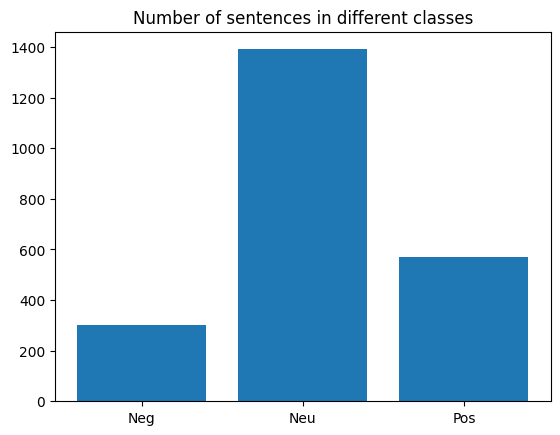

In [32]:
x = ('Neg', 'Neu', 'Pos')
num = [np.sum(np.array(raw_datasets["train"]['label']) == i) for i in range(3)]
plt.bar(x, num)
plt.title('Number of sentences in different classes')
plt.show()

We find that the number of records in different classes are a little imbalanced. Therefore we shall oversample the Negative and Positive classes.

In [33]:
## Oversample the Negative and Positive classes
from sklearn.utils import resample
from datasets import concatenate_datasets
from datasets import Dataset

Neg_class = tokenized_datasets['train'].filter(lambda example: example['label'] == 0)
Neu_class = tokenized_datasets['train'].filter(lambda example: example['label'] == 1)
Pos_class = tokenized_datasets['train'].filter(lambda example: example['label'] == 2)

Neg_oversampled = Dataset.from_dict(resample(Neg_class, replace=True, n_samples=len(Neu_class), random_state = 42))
Neu_oversampled = Dataset.from_dict(resample(Neu_class, replace=True, n_samples=len(Neu_class), random_state = 42))
Pos_oversampled = Dataset.from_dict(resample(Pos_class, replace=True, n_samples=len(Neu_class), random_state = 42))

train_oversampled = concatenate_datasets([Neg_oversampled, Neu_oversampled, Pos_oversampled])
train_oversampled

Dataset({
    features: ['sentence', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2505
})

In [34]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset_oversampled = train_oversampled.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols="labels",
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_validation_dataset = tokenized_datasets["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols="labels",
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

tf_test_dataset = tokenized_datasets["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols="labels",
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

# new optimizer
batch_size = 8
num_epochs = 3
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
opt = Adam(learning_rate=lr_scheduler)

## get, compile and train the model
model_oversampled = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_oversampled.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
model_oversampled.fit(tf_train_dataset_oversampled, validation_data=tf_validation_dataset, epochs=3)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_120', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/3
314/314 [==============================] - 57s 111ms/step - loss: 0.2242 - accuracy: 0.9122 - val_loss: 0.1088 - val_accuracy: 0.9713
Epoch 2/3
314/314 [==============================] - 20s 65ms/step - loss: 0.0228 - accuracy: 0.9964 - val_loss: 0.1564 - val_accuracy: 0.9647
Epoch 3/3
314/314 [==============================] - 16s 52ms/step - loss: 0.0197 - accuracy: 0.9972 - val_loss: 0.1564 - val_accuracy: 0.9647


In [35]:
## model prediction
preds_oversampled = model_oversampled.predict(tf_test_dataset)["logits"]
class_preds_oversampled = np.argmax(preds_oversampled, axis=1)

## calculate accuracy and f1 score
accuracy_train_oversampled = accuracy_score(class_preds_oversampled, fin_dataset_clean["test"]["label"])
f1_train_oversampled = f1_score(class_preds_oversampled, fin_dataset_clean["test"]["label"], average = "macro")
print("accuracy score = ", accuracy_train_oversampled, "\nf1 score = ", f1_train_oversampled)

57/57 [==============================] - 2s 15ms/step
accuracy score =  0.9426048565121413 
f1 score =  0.9219307111206234


We can see that the result doesn't change much, probably because the accuracy is already very high so it may reach a bottle neck and is hard to further improve.

### 4.Superior Error Analysis
In this part we analyze whether one class is harder to correctly classify than others. Then we see whether sentence length can affect classification accuracy. Finally we put sentence_length as a feature to train and test the model.

We calculate the accuracy of prediction for the three classes:

In [36]:
accuracy_list = []
for t in range(3):
  total = np.sum(np.array(fin_dataset_clean['test']['label']) == t)
  count = 0
  for i in range(len(fin_dataset_clean['test'])):
    if(fin_dataset_clean['test']['label'][i] == class_preds2[i] and fin_dataset_clean['test']['label'][i] == t):
      count += 1
  accuracy_list.append(count/total)
dictionary = {0:"Neg", 1:"Neu", 2:"Pos"}

for i in range(3):
    print("Accuracy of", dictionary[i], ": ", '{:.2%}'.format(accuracy_list[i]))

Accuracy of Neg :  91.04%
Accuracy of Neu :  97.79%
Accuracy of Pos :  93.91%


We plot confusion matrix for the predicted result of the fine-tuned model here.

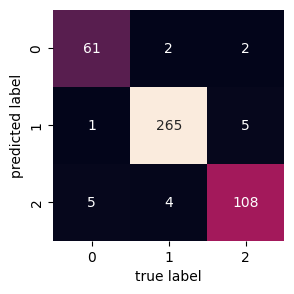

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize = (3,3))
mat = confusion_matrix(fin_dataset_clean['test']['label'], class_preds2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

We can see from the statistical result and the plot that the neutral class is predicted with the most accuracy while positive and negative classes are relatively harder to predict correctly.

We then want to see whether the length of sentence can affect prediction accuracy. Shorter sentences shall be easier to classify as they are normally less informative and in turn more of them shall simply be classified as "neutral" while longer sentences shall be more expressive and are more likely to be "positive" or "negative". In this sense, there will be balance among the three sentiments for long sentences, making them harder to classify.

In [38]:
# We get the length of sentences
def compute_sentence_length(example):
    return {"sentence_length": len(example["sentence"].split())}

fin_dataset_clean_with_length = fin_dataset_clean.map(compute_sentence_length)

In [39]:
accuracy_list2 = []
for t in range(5):
  total = 0
  count = 0
  for i in range(len(fin_dataset_clean_with_length['test'])):
    temp = fin_dataset_clean_with_length['test']['sentence_length'][i]
    if temp > np.quantile(fin_dataset_clean_with_length['test']['sentence_length'], 0.2*t) and temp < np.quantile(fin_dataset_clean_with_length['test']['sentence_length'], 0.2*t+0.2):
      total += 1
      if class_preds2[i] == fin_dataset_clean_with_length['test']['label'][i]:
        count += 1
  accuracy_list2.append(count/total)

for i in range(5):
    print("Accuracy of quantile ", '{:.2f}'.format(i*0.2), "to", '{:.2f}'.format(i*0.2+0.2), ": ", '{:.4%}'.format(accuracy_list2[i]))

Accuracy of quantile  0.00 to 0.20 :  100.0000%
Accuracy of quantile  0.20 to 0.40 :  95.6522%
Accuracy of quantile  0.40 to 0.60 :  96.0000%
Accuracy of quantile  0.60 to 0.80 :  93.0233%
Accuracy of quantile  0.80 to 1.00 :  92.7711%


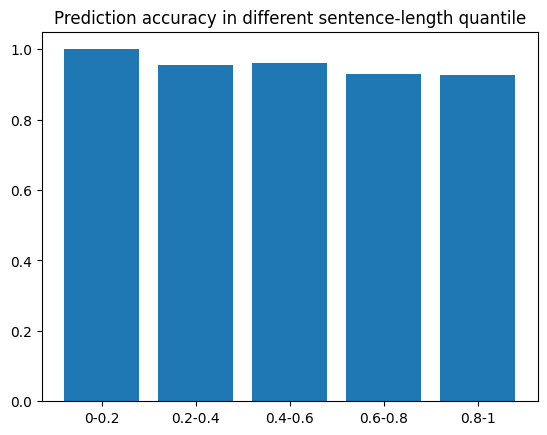

In [40]:
x = ('0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1')
num = accuracy_list2
plt.bar(x, num)
plt.title('Prediction accuracy in different sentence-length quantile')
plt.show()

We can see from the statistics that the longer the sentence, the harder it is to predict accurately, which is in line with our assumption.

We then add sentence_length as a feature to help prediction.

In [41]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["sentence"], truncation=True)

tokenized_datasets_with_length = fin_dataset_clean_with_length.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

Map:   0%|          | 0/453 [00:00<?, ? examples/s]

In [42]:
tf_train_dataset_with_length = tokenized_datasets_with_length["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols="labels",
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_validation_dataset_with_length = tokenized_datasets_with_length["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols="labels",
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

tf_test_dataset_with_length = tokenized_datasets_with_length["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols="labels",
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

## new optimizer
batch_size = 8
num_epochs = 3
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
opt = Adam(learning_rate=lr_scheduler)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [43]:
model_with_length = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_with_length.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
model_with_length.fit(tf_train_dataset_with_length, validation_data=tf_validation_dataset_with_length, epochs=3)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_140']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/3
170/170 [==============================] - 55s 169ms/step - loss: 0.4128 - accuracy: 0.8446 - val_loss: 0.1885 - val_accuracy: 0.9426
Epoch 2/3
170/170 [==============================] - 10s 58ms/step - loss: 0.0879 - accuracy: 0.9786 - val_loss: 0.1296 - val_accuracy: 0.9603
Epoch 3/3
170/170 [==============================] - 8s 48ms/step - loss: 0.0321 - accuracy: 0.9941 - val_loss: 0.1205 - val_accuracy: 0.9625


In [44]:
preds_with_length = model_with_length.predict(tf_test_dataset_with_length)["logits"]

class_preds_with_length = np.argmax(preds_with_length, axis=1)
accuracy_train_with_length = accuracy_score(class_preds_with_length, fin_dataset_clean_with_length["test"]["label"])
f1_train_with_length = f1_score(class_preds_with_length, fin_dataset_clean_with_length["test"]["label"], average = "macro")

print("accuracy score = ", accuracy_train_with_length, "\nf1 score = ", f1_train_with_length)

57/57 [==============================] - 2s 16ms/step
accuracy score =  0.9602649006622517 
f1 score =  0.9473581219315411


We can see that the result doesn't change much, probably because the accuracy is already very high so it may reach a bottle neck and is hard to further improve.

### 5.Experiment with different Pre-Trained models

In this part we choose a model based on bertweet (hyperlink: https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis) to classify sentences, with dataset and other techniques unchanged.

In [45]:
raw_datasets = load_dataset("financial_phrasebank", 'sentences_allagree')
raw_datasets = raw_datasets.map(
    lambda x: {"sentence": [html.unescape(o) for o in x["sentence"]]}, batched=True
)
fin_dataset_clean = raw_datasets["train"].train_test_split(train_size=0.6, seed=42)
fin_dataset_clean_temp = fin_dataset_clean['test'].train_test_split(train_size=0.5, seed=42)
fin_dataset_clean["validation"] = fin_dataset_clean_temp["train"]
fin_dataset_clean["test"] = fin_dataset_clean_temp["test"]

checkpoint = "finiteautomata/bertweet-base-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenized_datasets_new_model = fin_dataset_clean.map(tokenize_function, batched=True)
data_collator_new_model = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset_new_model = tokenized_datasets_new_model["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols="labels",
    shuffle=True,
    collate_fn=data_collator_new_model,
    batch_size=8,
)

tf_validation_dataset_new_model = tokenized_datasets_new_model["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols="labels",
    shuffle=False,
    collate_fn=data_collator_new_model,
    batch_size=8,
)

tf_test_dataset_new_model = tokenized_datasets_new_model["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols="labels",
    shuffle=False,
    collate_fn=data_collator_new_model,
    batch_size=8,
)

# new optimizer
batch_size = 8
num_epochs = 3
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
opt = Adam(learning_rate=lr_scheduler)

model_new_model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_new_model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
model_new_model.fit(tf_train_dataset_new_model, validation_data=tf_validation_dataset_new_model, epochs=3)

preds_new_model = model_new_model.predict(tf_test_dataset_new_model)["logits"]

class_preds_new_model = np.argmax(preds_new_model, axis=1)
accuracy_train_new_model = accuracy_score(class_preds_new_model, fin_dataset_clean["test"]["label"])
f1_train_new_model = f1_score(class_preds_new_model, fin_dataset_clean["test"]["label"], average = "macro")

print("accuracy score = ", accuracy_train_new_model, "\nf1 score = ", f1_train_new_model)

  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/453 [00:00<?, ? examples/s]

Map:   0%|          | 0/453 [00:00<?, ? examples/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at finiteautomata/bertweet-base-sentiment-analysis.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Epoch 1/3
170/170 [==============================] - 91s 257ms/step - loss: 0.2576 - accuracy: 0.9183 - val_loss: 0.1855 - val_accuracy: 0.9426
Epoch 2/3
170/170 [==============================] - 19s 113ms/step - loss: 0.0716 - accuracy: 0.9816 - val_loss: 0.1388 - val_accuracy: 0.9514
Epoch 3/3
57/57 [==============================] - 5s 35ms/step
accuracy score =  0.9558498896247241 
f1 score =  0.9404313807812724


We can see that the result is similar to that of the distilbert-based model we used before. This shows that the bertweet-based model is also good at sentiment analysis.

### 6.Experiment with Fine-Tuning
In this part we change the size of input to train the model. We resize the training set as 20%, 40%, 60%, 80%, 100% of original training set and see whether size of training set can affect prediction accuracy. 

In [46]:
accuracy_list = []
f1_list = []

ratios = [0.2, 0.4, 0.6, 0.8, 0.999]
for ratio in ratios:
    raw_datasets = load_dataset("financial_phrasebank", 'sentences_allagree')
    raw_datasets = raw_datasets.map(
        lambda x: {"sentence": [html.unescape(o) for o in x["sentence"]]}, batched=True
    )
    fin_dataset_clean = raw_datasets["train"].train_test_split(train_size=0.6, seed=42)
    fin_dataset_clean_temp = fin_dataset_clean['test'].train_test_split(train_size=0.5, seed=42)
    fin_dataset_clean["validation"] = fin_dataset_clean_temp["train"]
    fin_dataset_clean["test"] = fin_dataset_clean_temp["test"]
    fin_dataset_clean["train"] = fin_dataset_clean["train"].train_test_split(train_size=ratio, seed=42)["train"]
#    fin_dataset_clean["train"] = fin_dataset_clean["train"][:int(ratio*len(fin_dataset_clean["train"]))]

    checkpoint = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    tokenized_datasets_EFT = fin_dataset_clean.map(tokenize_function, batched=True)
    data_collator_EFT = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

    tf_train_dataset_EFT = tokenized_datasets_EFT["train"].to_tf_dataset(
        columns=["attention_mask", "input_ids"],
        label_cols="labels",
        shuffle=True,
        collate_fn=data_collator_EFT,
        batch_size=8,
    )

    tf_validation_dataset_EFT = tokenized_datasets_EFT["validation"].to_tf_dataset(
        columns=["attention_mask", "input_ids"],
        label_cols="labels",
        shuffle=False,
        collate_fn=data_collator_EFT,
        batch_size=8,
    )

    tf_test_dataset_EFT = tokenized_datasets_EFT["test"].to_tf_dataset(
        columns=["attention_mask", "input_ids"],
        label_cols="labels",
        shuffle=False,
        collate_fn=data_collator_EFT,
        batch_size=8,
    )

    # new optimizer
    batch_size = 8
    num_epochs = 3
    num_train_steps = len(tf_train_dataset) * num_epochs
    lr_scheduler = PolynomialDecay(
        initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
    )
    opt = Adam(learning_rate=lr_scheduler)

    model_EFT = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model_EFT.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    model_EFT.fit(tf_train_dataset_EFT, validation_data=tf_validation_dataset_EFT, epochs=3)

    preds_EFT = model_EFT.predict(tf_test_dataset_EFT)["logits"]

    class_preds_EFT = np.argmax(preds_EFT, axis=1)
    accuracy_list.append(accuracy_score(class_preds_EFT, fin_dataset_clean["test"]["label"]))
    f1_list.append(f1_score(class_preds_EFT, fin_dataset_clean["test"]["label"], average = "macro"))


  0%|          | 0/1 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassific

Epoch 1/3
34/34 [==============================] - 38s 391ms/step - loss: 0.7987 - accuracy: 0.6642 - val_loss: 0.5847 - val_accuracy: 0.7594
Epoch 2/3
34/34 [==============================] - 6s 180ms/step - loss: 0.3975 - accuracy: 0.8487 - val_loss: 0.4062 - val_accuracy: 0.7991
Epoch 3/3
57/57 [==============================] - 3s 19ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassific

Epoch 1/3
68/68 [==============================] - 40s 244ms/step - loss: 0.5973 - accuracy: 0.7551 - val_loss: 0.2558 - val_accuracy: 0.9294
Epoch 2/3
68/68 [==============================] - 7s 103ms/step - loss: 0.1597 - accuracy: 0.9558 - val_loss: 0.2012 - val_accuracy: 0.9426
Epoch 3/3
57/57 [==============================] - 3s 19ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassific

Epoch 1/3
102/102 [==============================] - 47s 232ms/step - loss: 0.4631 - accuracy: 0.8256 - val_loss: 0.1874 - val_accuracy: 0.9360
Epoch 2/3
102/102 [==============================] - 7s 70ms/step - loss: 0.1033 - accuracy: 0.9730 - val_loss: 0.2456 - val_accuracy: 0.9272
Epoch 3/3
57/57 [==============================] - 2s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassific

Epoch 1/3
136/136 [==============================] - 51s 203ms/step - loss: 0.4169 - accuracy: 0.8361 - val_loss: 0.1430 - val_accuracy: 0.9536
Epoch 2/3
136/136 [==============================] - 10s 72ms/step - loss: 0.0694 - accuracy: 0.9761 - val_loss: 0.1831 - val_accuracy: 0.9470
Epoch 3/3
57/57 [==============================] - 3s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassific

Epoch 1/3
170/170 [==============================] - 50s 159ms/step - loss: 0.3910 - accuracy: 0.8466 - val_loss: 0.1533 - val_accuracy: 0.9514
Epoch 2/3
170/170 [==============================] - 11s 63ms/step - loss: 0.0814 - accuracy: 0.9771 - val_loss: 0.1520 - val_accuracy: 0.9470
Epoch 3/3
57/57 [==============================] - 2s 15ms/step


In [47]:
print("training ratio    accuracy score    f1 score")
for i in range(len(accuracy_list)):
    print(ratios[i], '        ', '{:.2%}'.format(accuracy_list[i]), "        ", '{:.4f}'.format(f1_list[i]))

training ratio    accuracy score    f1 score
0.2          88.96%          0.8488
0.4          92.72%          0.9119
0.6          94.70%          0.9283
0.8          96.03%          0.9431
0.999          95.81%          0.9433


We can see that with input data size increasing, accuracy is also generally increasing, showing that larger input data size helps prediction. The overall accuracies are all very high, even 20% size of the original training set gives an accuracy of about 89%. As long as the training size reach 80% of the original training size, i.e., 1086 records, the accuracy will reach about 95%, which is largely acceptable statistically.

It doesn't matter which subset we choose as long as the records in the dataset are randomly ordered.